### Data Preprocessing

In [26]:
def diabetes_preprocessing():
    import pandas as pd
    import numpy as np

    # define path of dataset file
    data_path = '/Users/andrea/Code/CSC 440/Final Project/diabetic_data.csv' # MAKE PATH CHANGE HERE
    
    # assign first row of data to the column titles
    diabetics_files=pd.read_csv(data_path, header=None)
    diabetics_files.columns=diabetics_files.iloc[0]
    diabetes=diabetics_files.drop(diabetics_files.index[0])

    # drop unnecessary columns
    diabetes=diabetes.drop(columns=['weight','payer_code'])
    diabetes=diabetes.drop(columns=['number_outpatient','number_emergency','number_inpatient'])
    diabetes=diabetes.drop(columns=['metformin','repaglinide','nateglinide','chlorpropamide',
                          'glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                          'miglitol','troglitazone', 'tolazamide','examide','citoglipton', 'insulin','glyburide-metformin','glipizide-metformin',
                          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'])

    # rename columns
    diabetes.columns=['Encounter_Id','Patient_Nbr', 'Race','Gender','Age','Admission_Type_Id','Discharge_Disposition_Id',
                    'Admission_Source_Id','Time_in_Hospital','Medical_Specialty','Num_Lab_Procedures','Num_Procedures',
                    'Num_Medications','Diag_1', 'Diag_2', 'Diag_3','Number_Diagnoses','Max_Glu_Serum', 'A1Cresult', 'Change',
                    'DiabetesMed','Readmitted']

    # convert to integer type
    diabetes['Admission_Type_Id'] = diabetes['Admission_Type_Id'].astype('int64')
    diabetes['Discharge_Disposition_Id'] = diabetes['Discharge_Disposition_Id'].astype('int64')
    diabetes['Admission_Source_Id'] = diabetes['Admission_Source_Id'].astype('int64')
    diabetes['Encounter_Id']=diabetes['Encounter_Id'].astype('int64')
    diabetes['Patient_Nbr']=diabetes['Patient_Nbr'].astype('int64')
    diabetes['Time_in_Hospital']=diabetes['Time_in_Hospital'].astype('int64')
    diabetes['Num_Lab_Procedures']=diabetes['Num_Lab_Procedures'].astype('int64')
    diabetes['Num_Procedures']=diabetes['Num_Procedures'].astype('int64')
    diabetes['Num_Medications']=diabetes['Num_Medications'].astype('int64')
    diabetes['Number_Diagnoses']=diabetes['Number_Diagnoses'].astype('int64')
    
    # convert to categorical type
    diabetes['Race'] = diabetes['Race'].astype('category')
    diabetes['Gender'] = diabetes['Gender'].astype('category')
    diabetes['Age'] = diabetes['Age'].astype('category')
    diabetes['Medical_Specialty'] = diabetes['Medical_Specialty'].astype('category')
    diabetes['Diag_1'] = diabetes['Diag_1'].astype('category') # some entries have letter prefixes, so not entirely numeric
    diabetes['Diag_2'] = diabetes['Diag_2'].astype('category') # some entries have letter prefixes, so not entirely numeric
    diabetes['Diag_3'] = diabetes['Diag_3'].astype('category') # some entries have letter prefixes, so not entirely numeric
    diabetes['Max_Glu_Serum'] = diabetes['Max_Glu_Serum'].astype('category')
    diabetes['A1Cresult'] = diabetes['A1Cresult'].astype('category')
    diabetes['Change'] = diabetes['Change'].astype('category')
    diabetes['DiabetesMed'] = diabetes['DiabetesMed'].astype('category')
    diabetes['Readmitted'] = diabetes['Readmitted'].astype('category')
    
    # replace missing data ('?') with 'NaN'
    medical_specialty_array=diabetes['Medical_Specialty'].values
    medical_specialty_list=list(medical_specialty_array)
    for i in range(len(medical_specialty_list)):
        if '?' in medical_specialty_list[i]:                 
            medical_specialty_list[i]='NaN'
    medical_list_fixed=np.asarray(medical_specialty_list)
    diabetes['Medical_Specialty']=medical_list_fixed
    diabetes['Medical_Specialty'] = diabetes['Medical_Specialty'].astype('category')
    

    # replace missing data ('?') with 'NaN'
    race_array=diabetes['Race'].values
    race_list=list(race_array)
    for i in range(len(race_list)):
        if '?' in race_list[i]:                 
            race_list[i]='NaN'
    race_fixed=np.asarray(race_list)
    diabetes['Race']=race_fixed
    diabetes['Race'] = diabetes['Race'].astype('category')
    
    # replace missing data ('?') with 'NaN'
    diag_3_array=diabetes['Diag_3'].values
    diag_3_list=list(diag_3_array)
    for i in range(len(diag_3_list)):
        if '?' in diag_3_list[i]:                 
            diag_3_list[i]='NaN'
    diag_3_fixed=np.asarray(diag_3_list)
    diabetes['Diag_3']=diag_3_fixed
    diabetes['Diag_3'] = diabetes['Diag_3'].astype('category')
    
    # drop rows containing 'NaN'
    diabetes = diabetes.dropna(axis = 0)
    

    # remove duplicate patient entries (we only want to consider a patient's first encounter)
    diabetes.sort_values("Patient_Nbr", inplace=True) # sort patient numbers
    diabetes.drop_duplicates(subset='Patient_Nbr',inplace=True) # drop duplicates

    # remove patient entries who were admitted to hospice care or died
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 11].index, inplace=True)
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 13].index, inplace=True)
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 14].index, inplace=True)
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 19].index, inplace=True)
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 20].index, inplace=True)
    diabetes.drop(diabetes.loc[diabetes['Discharge_Disposition_Id']== 21].index, inplace=True)
    
    # convert the "Readmitted" column entries into two target classes: "YES" and "NO"
    diabetes["Readmitted"] = diabetes["Readmitted"].replace(['<30', '>30'], 'YES')
    
    return diabetes
    
    

In [27]:
diabetes_preprocessing().shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(69789, 22)

### Oversampling 

In [28]:
#     # class count
#     count_no_readmittance, count_readmittance = diabetes['Readmitted'].value_counts()
#     print(count_no_readmittance)
#     print(count_readmittance)

    
#     # divide by class
#     no_readmittance = diabetes[diabetes['Readmitted'] == 'NO']
#     readmittance = diabetes[diabetes['Readmitted'] == 'YES']
    
    
#     # over-sampling of readmitted class
#     readmittance_over = readmittance.sample(50000, replace=True)
    
#     # over-sampling of non-readmitted class
#     no_readmittance_over = no_readmittance.sample(50000, replace=True)
#     diabetes_over = pd.concat([readmittance_over, no_readmittance_over], axis=0)
    

#     print('Random over-sampling:')
#     print(diabetes_over['Readmitted'].value_counts())

#     diabetes_over['Readmitted'].value_counts().plot(kind='bar', title='Count (target)')
    
    
#     # convert modified 'Readmitted' column to category type
#     diabetes_over['Readmitted'] = diabetes_over['Readmitted'].astype('category') 

In [29]:
diabetes_preprocessing().dtypes

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Encounter_Id                   int64
Patient_Nbr                    int64
Race                        category
Gender                      category
Age                         category
Admission_Type_Id              int64
Discharge_Disposition_Id       int64
Admission_Source_Id            int64
Time_in_Hospital               int64
Medical_Specialty           category
Num_Lab_Procedures             int64
Num_Procedures                 int64
Num_Medications                int64
Diag_1                      category
Diag_2                      category
Diag_3                      category
Number_Diagnoses               int64
Max_Glu_Serum               category
A1Cresult                   category
Change                      category
DiabetesMed                 category
Readmitted                    object
dtype: object

### Feature Selection Using Random Forest Regressor

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

diabetes = diabetes_preprocessing()

# encode data as numeric
le = LabelEncoder()    
diabetes['Race'] = le.fit_transform(diabetes['Race'])
diabetes['Gender'] = le.fit_transform(diabetes['Gender'])
diabetes['Age'] = le.fit_transform(diabetes['Age'])
diabetes['Medical_Specialty'] = le.fit_transform(diabetes['Medical_Specialty'])
diabetes['Diag_1'] = le.fit_transform(diabetes['Diag_1'])
diabetes['Diag_2'] = le.fit_transform(diabetes['Diag_2'])
diabetes['Diag_3'] = le.fit_transform(diabetes['Diag_3'])
diabetes['Max_Glu_Serum'] = le.fit_transform(diabetes['Max_Glu_Serum'])
diabetes['A1Cresult'] = le.fit_transform(diabetes['A1Cresult'])
diabetes['Change'] = le.fit_transform(diabetes['Change'])
diabetes['DiabetesMed'] = le.fit_transform(diabetes['DiabetesMed'])
diabetes['Readmitted'] = le.fit_transform(diabetes['Readmitted'])

# specify the features and target
features= ["Race", "Gender", "Age", "Admission_Type_Id", "Discharge_Disposition_Id",
        "Admission_Source_Id", "Time_in_Hospital", "Medical_Specialty", "Num_Lab_Procedures", "Num_Procedures",
        "Num_Medications", "Diag_1", "Diag_2","Diag_3", "Number_Diagnoses", "Max_Glu_Serum", "A1Cresult", 
        "Change", "DiabetesMed"]  #"Patient_Nbr"
target = "Readmitted"

rfr = RandomForestRegressor()
rfr.fit(diabetes[features], diabetes[target])
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), features), 
             reverse=True))

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.1296, 'Num_Lab_Procedures'), (0.1169, 'Diag_3'), (0.1166, 'Diag_2'), (0.1157, 'Diag_1'), (0.101, 'Num_Medications'), (0.0692, 'Time_in_Hospital'), (0.0542, 'Medical_Specialty'), (0.0448, 'Age'), (0.0417, 'Num_Procedures'), (0.0393, 'Number_Diagnoses'), (0.0364, 'Discharge_Disposition_Id'), (0.026, 'Race'), (0.0236, 'Admission_Type_Id'), (0.0225, 'A1Cresult'), (0.0191, 'Admission_Source_Id'), (0.0175, 'Gender'), (0.0139, 'Change'), (0.0067, 'DiabetesMed'), (0.0054, 'Max_Glu_Serum')]


In [31]:
diabetes_preprocessing().head(20)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Encounter_Id,Patient_Nbr,Race,Gender,Age,Admission_Type_Id,Discharge_Disposition_Id,Admission_Source_Id,Time_in_Hospital,Medical_Specialty,...,Num_Medications,Diag_1,Diag_2,Diag_3,Number_Diagnoses,Max_Glu_Serum,A1Cresult,Change,DiabetesMed,Readmitted
1,24437208,135,Caucasian,Female,[50-60),2,1,1,8,Cardiology,...,33,401,997,560,8,None,None,Ch,Yes,YES
3,29758806,378,Caucasian,Female,[50-60),3,1,1,2,Surgery-Neuro,...,11,722,305,250,3,None,None,No,No,NO
4,189899286,729,Caucasian,Female,[80-90),1,3,7,4,InternalMedicine,...,23,820,493,E880,9,None,>7,No,Yes,NO
5,64331490,774,Caucasian,Female,[80-90),1,1,7,3,InternalMedicine,...,20,274,427,416,9,None,>8,Ch,Yes,NO
6,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,InternalMedicine,...,5,590,220,250,3,None,None,No,Yes,NO
11,83281464,1152,AfricanAmerican,Female,[60-70),1,1,7,12,Hematology/Oncology,...,18,282,287,466,5,None,None,Ch,Yes,NO
12,66197028,1305,Caucasian,Female,[60-70),3,1,1,9,InternalMedicine,...,16,491,428,250.01,9,None,None,No,Yes,NO
13,60254142,1314,Caucasian,Female,[40-50),2,1,1,2,InternalMedicine,...,13,996,411,401,9,None,None,No,Yes,YES
16,171414378,1629,Caucasian,Male,[70-80),3,6,4,14,NaN,...,15,V57,719,438,7,None,None,No,Yes,YES
17,14897280,2025,Caucasian,Female,[70-80),2,3,1,12,InternalMedicine,...,18,682,707,560,9,None,Norm,Ch,Yes,NO


In [32]:
diabetes_preprocessing().shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(69789, 22)

### Apriori implementation

In [33]:
def apriori(dataframe):
    import numpy as np
    import apyori
    
    new_diabetes = dataframe.copy() # create a copy of the dataframe

    admission_type_array=new_diabetes['Admission_Type_Id'].values
    admission_type_list=list(admission_type_array)
    for i in range(len(admission_type_list)):               
            admission_type_list[i]='Admit Type:' + " " + str(admission_type_list[i]) 
    admission_type_fixed=np.asarray(admission_type_list)
    new_diabetes['Admission_Type_Id']=admission_type_fixed

    discharge_type_array=new_diabetes['Discharge_Disposition_Id'].values
    discharge_type_list=list(discharge_type_array)
    for i in range(len(discharge_type_list)):               
            discharge_type_list[i]='Discharge Disp:' + " " + str(discharge_type_list[i]) 
    discharge_type_fixed=np.asarray(discharge_type_list)
    new_diabetes['Discharge_Disposition_Id']=discharge_type_fixed

    admission_source_array=new_diabetes['Admission_Source_Id'].values
    admission_source_list=list(admission_source_array)
    for i in range(len(admission_source_list)):               
            admission_source_list[i]='Admission Source:' + " " + str(admission_source_list[i]) 
    admission_source_fixed=np.asarray(admission_source_list)
    new_diabetes['Admission_Source_Id']=admission_source_fixed


    hospital_time_array=new_diabetes['Time_in_Hospital'].values
    hospital_time_list=list(hospital_time_array)
    for i in range(len(hospital_time_list)):               
            hospital_time_list[i]='Time in Hospital:' + " " + str(hospital_time_list[i]) 
    hospital_time_fixed=np.asarray(hospital_time_list)
    new_diabetes['Time_in_Hospital']=hospital_time_fixed

    lab_procedure_array=new_diabetes['Num_Lab_Procedures'].values
    lab_procedure_list=list(lab_procedure_array)
    for i in range(len(lab_procedure_list)):               
            lab_procedure_list[i]='Num_Lab_Procedures:' + " " + str(lab_procedure_list[i]) 
    lab_procedure_fixed=np.asarray(lab_procedure_list)
    new_diabetes['Num_Lab_Procedures']=lab_procedure_fixed

    procedure_array=new_diabetes['Num_Procedures'].values
    procedure_list=list(procedure_array)
    for i in range(len(procedure_list)):               
            procedure_list[i]='Num_Procedures:' + " " + str(procedure_list[i]) 
    procedure_fixed=np.asarray(procedure_list)
    new_diabetes['Num_Procedures']=procedure_fixed
    new_diabetes['Num_Procedures']

    medications_array=new_diabetes['Num_Medications'].values
    medications_list=list(medications_array)
    for i in range(len(medications_list)):               
            medications_list[i]='Num_Medications:' + " " + str(medications_list[i]) 
    medications_fixed=np.asarray(medications_list)
    new_diabetes['Num_Medications']=medications_fixed

    diag1_array=new_diabetes['Diag_1'].values
    diag1_list=list(diag1_array)
    for i in range(len(diag1_list)):               
        diag1_list[i]='Diag_1:' + " " + str(diag1_list[i]) 
    diag1_fixed=np.asarray(diag1_list)
    new_diabetes['Diag_1']=diag1_fixed

    diag2_array=new_diabetes['Diag_2'].values
    diag2_list=list(diag2_array)
    for i in range(len(diag2_list)):               
        diag2_list[i]='Diag_2:' + " " + str(diag2_list[i]) 
    diag2_fixed=np.asarray(diag2_list)
    new_diabetes['Diag_2']=diag2_fixed

    diag3_array=new_diabetes['Diag_3'].values
    diag3_list=list(diag3_array)
    for i in range(len(diag3_list)):               
        diag3_list[i]='Diag_3:' + " " + str(diag3_list[i]) 
    diag3_fixed=np.asarray(diag3_list)
    new_diabetes['Diag_3']=diag3_fixed

    diagnoses_array=new_diabetes['Number_Diagnoses'].values
    diagnoses_list=list(diagnoses_array)
    for i in range(len(diagnoses_list)):               
        diagnoses_list[i]='Number_Diagnoses:' + " " + str(diagnoses_list[i]) 
    diagnoses_fixed=np.asarray(diagnoses_list)
    new_diabetes['Number_Diagnoses']=diagnoses_fixed

    glu_serum_array=new_diabetes['Max_Glu_Serum'].values
    glu_serum_list=list(glu_serum_array)
    for i in range(len(glu_serum_list)):               
        glu_serum_list[i]='Max_Glu_Serum:' + " " + str(glu_serum_list[i]) 
    glu_serum_fixed=np.asarray(glu_serum_list)
    new_diabetes['Max_Glu_Serum']=glu_serum_fixed

    cresult_array=new_diabetes['A1Cresult'].values
    cresult_list=list(cresult_array)
    for i in range(len(cresult_list)):               
        cresult_list[i]='A1Cresult:' + " " + str(cresult_list[i]) 
    cresult_fixed=np.asarray(cresult_list)
    new_diabetes['A1Cresult']=cresult_fixed

    change_array=new_diabetes['Change'].values
    change_list=list(change_array)
    for i in range(len(change_list)):               
        change_list[i]='Change:' + " " + str(change_list[i]) 
    change_fixed=np.asarray(change_list)
    new_diabetes['Change']=change_fixed

    diabetesmed_array=new_diabetes['DiabetesMed'].values
    diabetesmed_list=list(diabetesmed_array)
    for i in range(len(diabetesmed_list)):               
        diabetesmed_list[i]='DiabetesMed:' + " " + str(diabetesmed_list[i]) 
    diabetesmed_fixed=np.asarray(diabetesmed_list)
    new_diabetes['DiabetesMed']=diabetesmed_fixed

    readmitted_array=new_diabetes['Readmitted'].values
    readmitted_list=list(readmitted_array)
    for i in range(len(readmitted_list)):               
        readmitted_list[i]='Readmitted:' + " " + str(readmitted_list[i]) 
    readmitted_fixed=np.asarray(readmitted_list)
    new_diabetes['Readmitted']=readmitted_fixed

    # convert dataframe into a list of lists
    array=new_diabetes.values
    diabetes_to_list=array.tolist()
    for i in range(len(diabetes_to_list)):
        for j in range(22):
            diabetes_to_list[i][j]=str(diabetes_to_list[i][j])
            
    association_rules=apyori.apriori(diabetes_to_list,min_support=0.50, max_length=5)
    association_rules
    results=list(association_rules)
    print(results)

In [34]:
apriori(diabetes_preprocessing())

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


[RelationRecord(items=frozenset({'A1Cresult: None'}), support=0.8179369241571022, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'A1Cresult: None'}), confidence=0.8179369241571022, lift=1.0)]), RelationRecord(items=frozenset({'Admission Source: 7'}), support=0.5342245912679648, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Admission Source: 7'}), confidence=0.5342245912679648, lift=1.0)]), RelationRecord(items=frozenset({'Admit Type: 1'}), support=0.5094069265930161, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Admit Type: 1'}), confidence=0.5094069265930161, lift=1.0)]), RelationRecord(items=frozenset({'Caucasian'}), support=0.7472667612374443, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Caucasian'}), confidence=0.7472667612374443, lift=1.0)]), RelationRecord(items=frozenset({'Change: No'}), support=0.5492269555374056, ordered_statistics=

### Naive Bayes' Implementation 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Accuracy: 0.6087548359363806
Precision: 0.458319550115779
Recall: 0.26598195430984833
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     17498
           1       0.46      0.27      0.34     10418

   micro avg       0.61      0.61      0.61     27916
   macro avg       0.55      0.54      0.53     27916
weighted avg       0.58      0.61      0.58     27916

[[14223  3275]
 [ 7647  2771]]


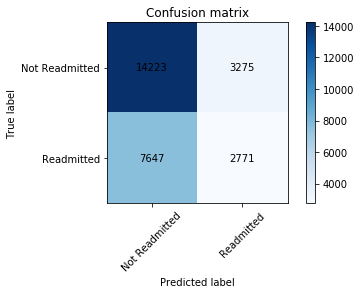

In [36]:
def naive_bayes():
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn import metrics
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from pandas_ml import ConfusionMatrix

    # load pre-processed dataframe
    diabetes= diabetes_preprocessing()

    
    # encode categorical data as a numeric type
    le = LabelEncoder()
   
    # categorical data
    diabetes['Race'] = le.fit_transform(diabetes['Race'])
    diabetes['Gender'] = le.fit_transform(diabetes['Gender'])
    diabetes['Age'] = le.fit_transform(diabetes['Age'])
    diabetes['Medical_Specialty'] = le.fit_transform(diabetes['Medical_Specialty'])
    diabetes['Diag_1'] = le.fit_transform(diabetes['Diag_1'])
    diabetes['Diag_2'] = le.fit_transform(diabetes['Diag_2'])
    diabetes['Diag_3'] = le.fit_transform(diabetes['Diag_3'])
    diabetes['Max_Glu_Serum'] = le.fit_transform(diabetes['Max_Glu_Serum'])
    diabetes['A1Cresult'] = le.fit_transform(diabetes['A1Cresult'])
    diabetes['Change'] = le.fit_transform(diabetes['Change'])
    diabetes['DiabetesMed'] = le.fit_transform(diabetes['DiabetesMed'])
    diabetes['Readmitted'] = le.fit_transform(diabetes['Readmitted'])


    # specify the features and target
    features= ["Race", "Gender", "Age", "Admission_Type_Id", "Discharge_Disposition_Id",
            "Admission_Source_Id", "Time_in_Hospital", "Medical_Specialty", "Num_Lab_Procedures", "Num_Procedures",
            "Num_Medications", "Diag_1", "Diag_2","Diag_3", "Number_Diagnoses", "Max_Glu_Serum", "A1Cresult", 
            "Change", "DiabetesMed"]  #"Patient_Nbr"
    
    relevant_features = ["Num_Lab_Procedures", "Diag_1", "Diag_2", "Diag_3", "Num_Medications", "Time_in_Hospital", 'Medical_Specialty', 'Age',
                        'Num_Procedures', 'Number_Diagnoses']
    target = "Readmitted"   

    # split the data into 40% test and 60% training
    features_train, features_test, target_train, target_test = train_test_split(diabetes[relevant_features], diabetes[target],
                                                           test_size = 0.40)
    model = GaussianNB() # create model
    model.fit(features_train, target_train)
    pred = model.predict(features_test) # make predictions on the test features
    
    print("Accuracy:",metrics.accuracy_score(target_test, pred))
    print("Precision:",metrics.precision_score(target_test, pred))
    print("Recall:",metrics.recall_score(target_test, pred))
    print(metrics.classification_report(target_test, pred))
    cnf_matrix = metrics.confusion_matrix(target_test, pred)
    print(cnf_matrix)
    
    return cnf_matrix
    

import numpy as np
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = naive_bayes()
plot_confusion_matrix(cm, ['Not Readmitted', 'Readmitted'])

In [ ]:
naive_bayes()
#diabetes['Predictions']=naive_bayes(diabetes_preprocessing())
#diabetes.head(5)




In [ ]:
#from pyarc import CBA, TransactionDB
#from pyarc.algorithms import (top_rules, createCARs, M1Algorithm)

# split the dataframe into training and testing data
#new_diabetes.shape
#new_diabetes_training = new_diabetes.iloc[:53000,:] # split at the 53,000 row entry (approx. 75% of data)
#new_diabetes_test = new_diabetes.iloc[53000:,:]

#diabetes_train=TransactionDB.from_DataFrame(new_diabetes_training)
#diabetes_test=TransactionDB.from_DataFrame(new_diabetes_test)
#train_rules=diabetes_train.string_representation


#rules=top_rules(train_rules)
#cars=createCARs(rules)
#classifier=M1Algorithm(cars,diabetes_train).build()
#accuracy=classifier.test_transactions(diabetes_test)


### Support  Vector Machine (SVM) Implementation

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.6247671586187132
Precision: 0.450261780104712
Recall: 0.008224942616679418
              precision    recall  f1-score   support

           0       0.63      0.99      0.77     17460
           1       0.45      0.01      0.02     10456

   micro avg       0.62      0.62      0.62     27916
   macro avg       0.54      0.50      0.39     27916
weighted avg       0.56      0.62      0.49     27916

[[17355   105]
 [10370    86]]


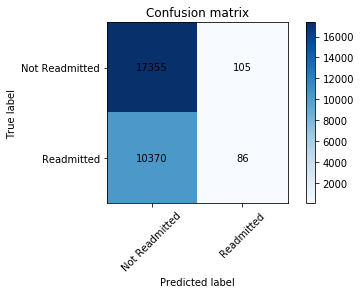

In [37]:
def SVM():
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn import metrics
    import numpy as np
    
        
    # encode data
    le = LabelEncoder()
    
    # categorical data
    diabetes['Race'] = le.fit_transform(diabetes['Race'])
    diabetes['Gender'] = le.fit_transform(diabetes['Gender'])
    diabetes['Age'] = le.fit_transform(diabetes['Age'])
    diabetes['Medical_Specialty'] = le.fit_transform(diabetes['Medical_Specialty'])
    diabetes['Diag_1'] = le.fit_transform(diabetes['Diag_1'])
    diabetes['Diag_2'] = le.fit_transform(diabetes['Diag_2'])
    diabetes['Diag_3'] = le.fit_transform(diabetes['Diag_3'])
    diabetes['Max_Glu_Serum'] = le.fit_transform(diabetes['Max_Glu_Serum'])
    diabetes['A1Cresult'] = le.fit_transform(diabetes['A1Cresult'])
    diabetes['Change'] = le.fit_transform(diabetes['Change'])
    diabetes['DiabetesMed'] = le.fit_transform(diabetes['DiabetesMed'])
    diabetes['Readmitted'] = le.fit_transform(diabetes['Readmitted'])

    # specify the features and target
    features = ["Race", "Gender", "Age", "Admission_Type_Id", "Discharge_Disposition_Id",
            "Admission_Source_Id", "Time_in_Hospital", "Medical_Specialty", "Num_Lab_Procedures", "Num_Procedures",
            "Num_Medications", "Diag_1", "Diag_2","Diag_3", "Number_Diagnoses", "Max_Glu_Serum", "A1Cresult", 
            "Change", "DiabetesMed"] # Encounter_Id is omitted from the features since each one is unique
    relevant_features = ["Num_Lab_Procedures", "Diag_1", "Diag_2", "Diag_3", "Num_Medications", "Time_in_Hospital", 'Medical_Specialty', 'Age',
                        'Num_Procedures', 'Number_Diagnoses']
    target = "Readmitted"
    
    # split the data into training and testing sets
    features_train, features_test, target_train, target_test = train_test_split(diabetes[relevant_features], diabetes[target], test_size=0.40) # 60% training and 40% test

    # train classifier 
    sv_classifier = SVC(kernel='rbf')  
    sv_classifier.fit(features_train, target_train)  

    # make a prediction
    target_pred = sv_classifier.predict(features_test)

    print("Accuracy:",metrics.accuracy_score(target_test, target_pred))
    print("Precision:",metrics.precision_score(target_test, target_pred))
    print("Recall:",metrics.recall_score(target_test, target_pred))
    cnf_matrix = metrics.confusion_matrix(target_test, target_pred)  
    print(metrics.classification_report(target_test, target_pred))
    print(cnf_matrix)

    
    return cnf_matrix

    import numpy as np
    from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = SVM()
plot_confusion_matrix(cm, ['Not Readmitted', 'Readmitted'])

### Neural Network Implementation

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (0,1,6,7,8,9,12,13,14,15,16,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1

Epoch 1/10
41873/41873 [==============================] - 8s 201us/step - loss: 0.6504 - acc: 0.6264
Epoch 2/10
41873/41873 [==============================] - 7s 178us/step - loss: 0.6483 - acc: 0.6266
Epoch 3/10
41873/41873 [==============================] - 8s 187us/step - loss: 0.6476 - acc: 0.6266
Epoch 4/10
41873/41873 [==============================] - 8s 183us/step - loss: 0.6476 - acc: 0.6266
Epoch 5/10
41873/41873 [==============================] - 7s 178us/step - loss: 0.6473 - acc: 0.6266
Epoch 6/10
41873/41873 [==============================] - 8s 187us/step - loss: 0.6472 - acc: 0.6266
Epoch 7/10
41873/41873 [==============================] - 8s 193us/step - loss: 0.6469 - acc: 0.6266
Epoch 8/10
41873/41873 [==============================] - 8s 183us/step - loss: 0.6468 - acc: 0.6266
Epoch 9/10
41873/41873 [==============================] - 8s 182us/step - loss: 0.6466 - acc: 0.6266
Epoch 10/10
41873/41873 [==============================] - 8s 200us/step - loss: 0.6462 - a

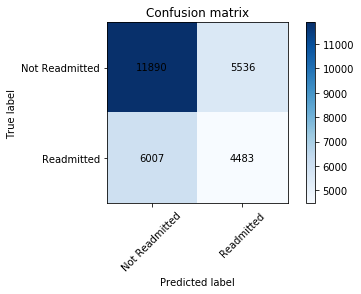

In [39]:
def neuralnetwork():
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn import metrics
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix
    from keras.models import Sequential
    from keras.layers import Dense
    import numpy as np
    import tensorflow
    import theano
    from matplotlib import pyplot as plt
    
    diabetes=diabetes_preprocessing()
    
    
    NN=LabelEncoder()
    
    diabetes['Race'] = NN.fit_transform(diabetes['Race'])
    diabetes['Gender'] = NN.fit_transform(diabetes['Gender'])
    diabetes['Age'] = NN.fit_transform(diabetes['Age'])
    diabetes['Medical_Specialty'] = NN.fit_transform(diabetes['Medical_Specialty'])
    diabetes['Diag_1'] = NN.fit_transform(diabetes['Diag_1'])
    diabetes['Diag_2'] = NN.fit_transform(diabetes['Diag_2'])
    diabetes['Diag_3'] = NN.fit_transform(diabetes['Diag_3'])
    diabetes['Max_Glu_Serum'] = NN.fit_transform(diabetes['Max_Glu_Serum'])
    diabetes['A1Cresult'] = NN.fit_transform(diabetes['A1Cresult'])
    diabetes['Change'] = NN.fit_transform(diabetes['Change'])
    diabetes['DiabetesMed'] = NN.fit_transform(diabetes['DiabetesMed'])
    diabetes['Readmitted'] = NN.fit_transform(diabetes['Readmitted'])
    
   
    
    features = ["Race", "Gender", "Age", "Admission_Type_Id", "Discharge_Disposition_Id",
            "Admission_Source_Id", "Time_in_Hospital", "Medical_Specialty", "Num_Lab_Procedures", "Num_Procedures",
            "Num_Medications", "Diag_1", "Diag_2","Diag_3", "Number_Diagnoses", "Max_Glu_Serum", "A1Cresult", 
            "Change", "DiabetesMed"] # Encounter_Id is omitted from the features since each one is unique
    relevant_features = ["Num_Lab_Procedures", "Diag_1", "Diag_2", "Diag_3", "Num_Medications", "Time_in_Hospital", 'Medical_Specialty', 'Age',
                        'Num_Procedures', 'Number_Diagnoses']
    target = "Readmitted"
    
    features_train, features_test, target_train, target_test = train_test_split(diabetes[relevant_features], diabetes[target], test_size = 0.40)
    
    sc=StandardScaler()
    features_train=sc.fit_transform(features_train)
    features_test=sc.transform(features_test)
    
    classifier = Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu', input_dim = 10))
    # Adding the second hidden layer
    classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))
    # Adding the third hidden layer
    classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu'))
    # Adding the output layer
    classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))
    
    # Compiling Neural Network
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Fitting our model 
    classifier.fit(features_train, target_train, batch_size = 10, nb_epoch = 10)

    target_pred = classifier.predict(features_test)
    #print(max(target_pred))
    #print(min(target_pred))
    target_pred=(target_pred>0.42)
#     target_pred=np.argmax(target_pred,axis=1)
    #print(np.count_nonzero(target_pred))
    #print(target_pred)
    print("Accuracy:",metrics.accuracy_score(target_test, target_pred))
    print("Precision:",metrics.precision_score(target_test, target_pred))
    print("Recall:",metrics.recall_score(target_test, target_pred))
    print(metrics.classification_report(target_test, target_pred))
    cnf_matrix = metrics.confusion_matrix(target_test, target_pred)

    print(cnf_matrix)

    
    return cnf_matrix
   
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    import numpy as np
    from matplotlib import pyplot as plt
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = neuralnetwork()
plot_confusion_matrix(cm, ['Not Readmitted', 'Readmitted'])